In [2]:
import open3d as o3d
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
import random
import seaborn as sns
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
df = pd.read_csv('data\LIDAR data\lidar_data.csv')

In [6]:
df.head()

,x,y,z,red,green,blue,scalar_Intensity,scalar_GPSTime,scalar_ScanAngleRank,scalar_Label,color
0,144.500000,949.984009,144.350006,99,28,36,48.0,324750.72,12.0,4.0,"rgb(99.0,28.0,36.0)"
1,144.944000,946.268982,146.248001,144,161,155,2.0,324759.78,15.0,4.0,"rgb(144.0,161.0,155.0)"
2,129.983994,955.427002,140.850998,99,94,100,8.0,324749.56,0.0,1.0,"rgb(99.0,94.0,100.0)"
3,148.457001,939.979004,149.169998,83,74,67,10.0,324776.90,10.0,4.0,"rgb(83.0,74.0,67.0)"
4,125.126999,952.778992,140.792007,74,78,79,8.0,324762.22,5.0,1.0,"rgb(74.0,78.0,79.0)"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215672 entries, 0 to 215671
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   x                     215672 non-null  float64
 1   y                     215672 non-null  float64
 2   z                     215672 non-null  float64
 3   red                   215672 non-null  int64  
 4   green                 215672 non-null  int64  
 5   blue                  215672 non-null  int64  
 6   scalar_Intensity      215672 non-null  float64
 7   scalar_GPSTime        215672 non-null  float64
 8   scalar_ScanAngleRank  215672 non-null  float64
 9   scalar_Label          215672 non-null  float64
 10  color                 215672 non-null  object 
dtypes: float64(7), int64(3), object(1)
memory usage: 18.1+ MB


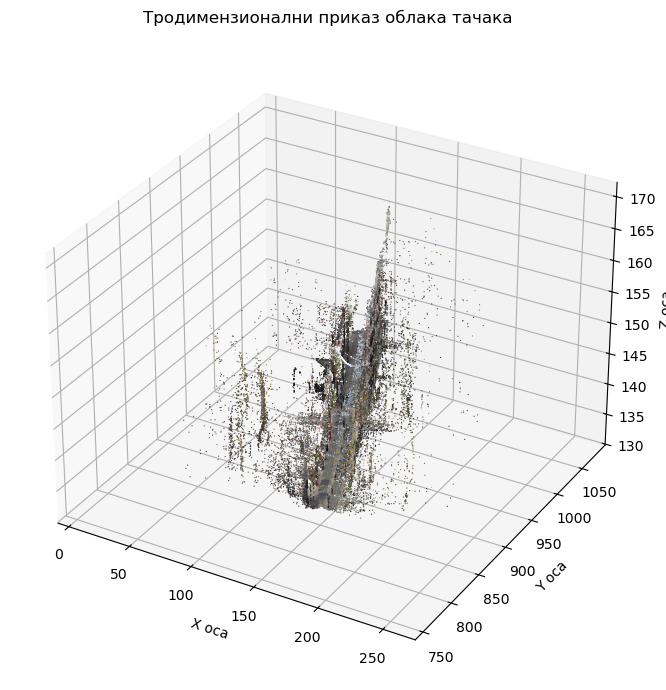

In [8]:
rgb = df[['red', 'green', 'blue']].to_numpy() / 255

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    df['x'], df['y'], df['z'],
    c=rgb, s=0.8, alpha=0.9, linewidths=0
)

ax.set_title('Тродимензионални приказ облака тачака', pad=15)
ax.set_xlabel('X оса')
ax.set_ylabel('Y оса')
ax.set_zlabel('Z оса')

ax.grid(True)
plt.tight_layout()
plt.show()

In [9]:
def parse_color_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    ns = {'cc': 'http://www.cloudcompare.org/'}
    data = root.find('.//Data', ns)
    
    color_map = {}
    for step in data.findall('step'):
        r, g, b = (int(step.get(ch)) for ch in ('r', 'g', 'b'))
        pos = float(step.get('pos'))
        color_map[int(pos * 8)] = (r / 255, g / 255, b / 255)
    return color_map


label_categories = {
    0: 'Unclassified', 1: 'Ground', 2: 'Road_markings', 3: 'Natural',
    4: 'Building', 5: 'Utility_line', 6: 'Pole', 7: 'Car', 8: 'Fence'
}


def get_category_colors(color_map):
    return {k: color_map[k] for k in label_categories if k in color_map}


xml_path = 'data\LIDAR data\Colors.xml'
color_map = parse_color_xml(xml_path)
category_colors = get_category_colors(color_map)

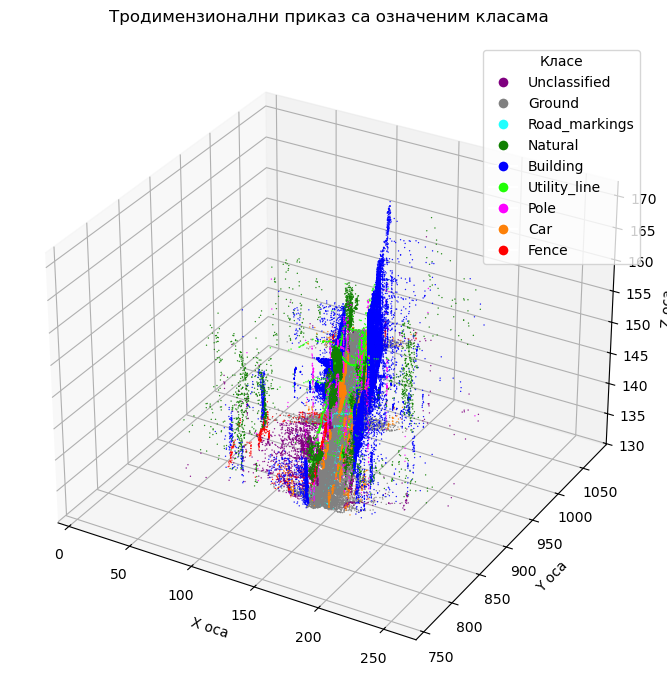

In [10]:
df['color'] = df.apply(lambda r: f'rgb({r.red},{r.green},{r.blue})', axis=1)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    df['x'], df['y'], df['z'],
    c=[color_map.get(lbl, (1, 1, 1)) for lbl in df['scalar_Label']],
    s=1, alpha=0.9, linewidths=0
)

ax.set_title('Тродимензионални приказ са означеним класама', pad=15)
ax.set_xlabel('X оса')
ax.set_ylabel('Y оса')
ax.set_zlabel('Z оса')

handles = [
    plt.Line2D(
        [0], [0],
        marker='o', color='w',
        markerfacecolor=category_colors[i],
        markersize=8,
        label=label_categories[i]
    )
    for i in sorted(category_colors)
]
ax.legend(handles=handles, title='Класе', loc='best')

plt.tight_layout()
plt.show()


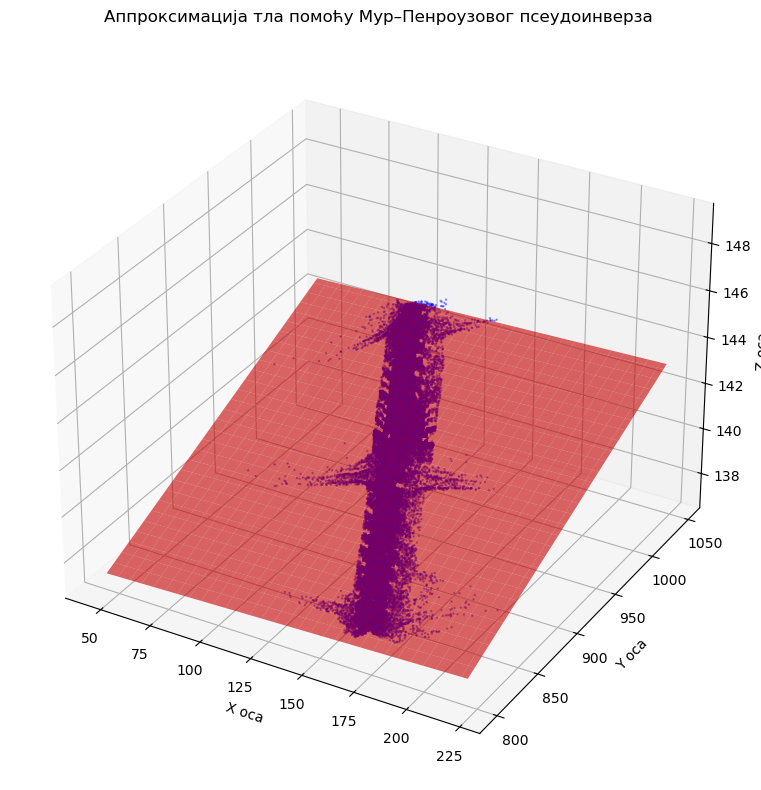

In [ ]:
ground_df = df[df['scalar_Label'] == 1]
X = ground_df[['x', 'y', 'z']].to_numpy()

A = np.c_[X[:,0], X[:,1], np.ones(X.shape[0])]
b = X[:,2]
a, b_coef, c = np.linalg.pinv(A) @ b

x_range = np.linspace(ground_df['x'].min(), ground_df['x'].max(), 60)
y_range = np.linspace(ground_df['y'].min(), ground_df['y'].max(), 60)
x_grid, y_grid = np.meshgrid(x_range, y_range)
z_grid = a * x_grid + b_coef * y_grid + c

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(ground_df['x'], ground_df['y'], ground_df['z'], c='blue', s=0.5, alpha=0.4)
ax.plot_surface(x_grid, y_grid, z_grid, color='red', alpha=0.6)

ax.set_title('Аппроксимација тла помоћу Мур–Пенроузовог псеудоинверза', pad=15)
ax.set_xlabel('X оса')
ax.set_ylabel('Y оса')
ax.set_zlabel('Z оса')

plt.tight_layout()
plt.show()

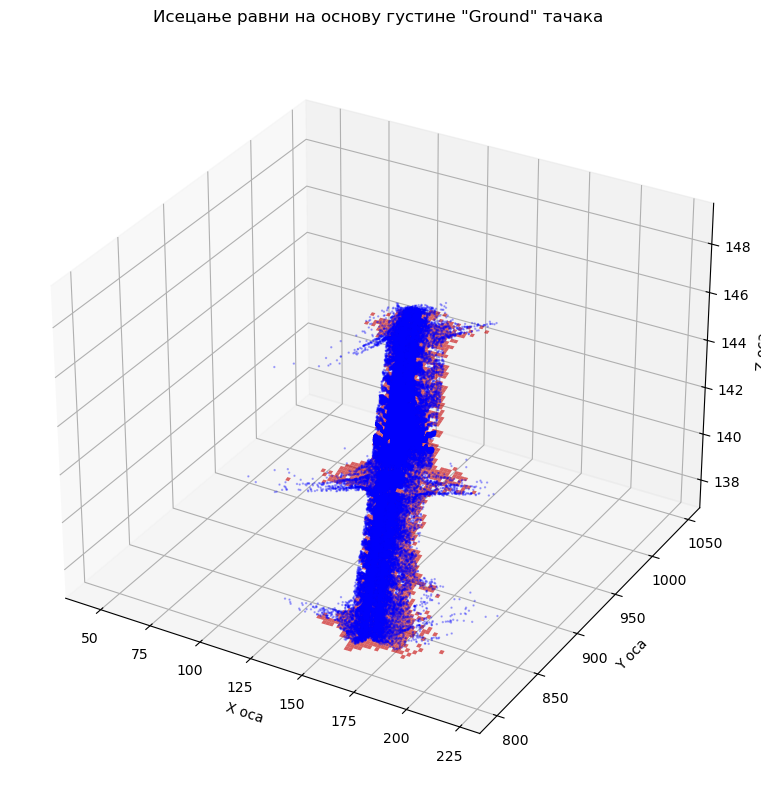

In [29]:
from scipy.stats import binned_statistic_2d

ground_df = df[df['scalar_Label'] == 1]
X = ground_df[['x','y','z']].to_numpy()

A = np.c_[X[:,0], X[:,1], np.ones(X.shape[0])]
b = X[:,2]
a, b_coef, c = np.linalg.pinv(A) @ b

x_range = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_range = np.linspace(X[:,1].min(), X[:,1].max(), 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
z_grid = a * x_grid + b_coef * y_grid + c

density, x_edges, y_edges, _ = binned_statistic_2d(
    X[:,0], X[:,1], None, statistic='count', bins=100
)
density = density.T

threshold = np.percentile(density[density > 0], 15)  
mask = density > threshold

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c='blue', s=0.5, alpha=0.3)

for i in range(mask.shape[0] - 1):
    for j in range(mask.shape[1] - 1):
        if mask[i, j]:
            x_patch = x_grid[i:i+2, j:j+2]
            y_patch = y_grid[i:i+2, j:j+2]
            z_patch = z_grid[i:i+2, j:j+2]
            ax.plot_surface(x_patch, y_patch, z_patch, color='red', alpha=0.6, linewidth=0)

ax.set_title('Исецање равни на основу густине "Ground" тачака', pad=15)
ax.set_xlabel('X оса')
ax.set_ylabel('Y оса')
ax.set_zlabel('Z оса')

plt.tight_layout()
plt.show()